# Music/Speech Classification II
- with `nn.Conv1d()`
- audio signal processing
- neural network for classification
- data: http://marsyas.info/downloads/datasets.html
- main ref: https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html
- see also [Speaker Verification](https://github.com/HarryVolek/PyTorch_Speaker_Verification)

### http://marsyas.info/downloads/datasets.html

- A similar dataset which was collected for the purposes of music/speech discrimination. 
- The dataset consists of 120 tracks, each 30 seconds long. 
- Each class (music/speech) has 60 examples. 
- The tracks are all 22050Hz Mono 16-bit audio files in .wav format.

In [1]:
import torch
torch.manual_seed(0)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(15,3.4)

In [2]:
mpl.rcParams['figure.figsize'] = (14, 3.4)

### A music sample from dataset

In [4]:
import librosa

audio_datafile = '../data/music_speech/music_wav/bagpipe.wav'
x, sf = librosa.load(audio_datafile)
print(f'shape: {x.shape}\nsampling freq: {sf}\ntime duration: len/sf = {x.shape[0]/sf} seconds')

shape: (661500,)
sampling freq: 22050
time duration: len/sf = 30.0 seconds


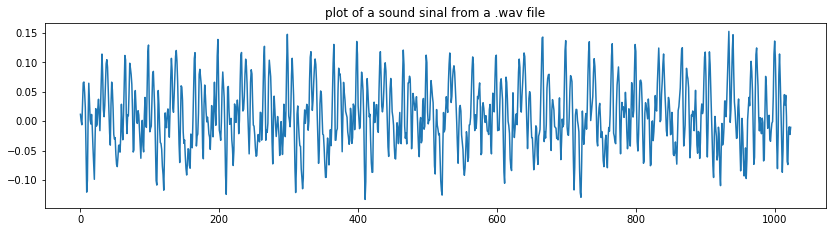

In [5]:
plt.title('plot of a sound sinal from a .wav file')
plt.plot(x[:1024])

In [6]:
import IPython.display as ipd
ipd.Audio(audio_datafile)

Text(0.5, 1.0, 'a music waveplot with librosa.display.waveplot')

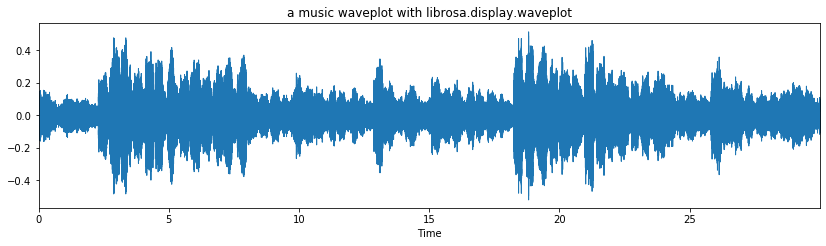

In [7]:
import librosa.display
#plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sf)
plt.title('a music waveplot with librosa.display.waveplot')

### A speech sample from dataset

shape: (661500,)
sampling freq: 22050
time duration: len/sf = 30.0 seconds


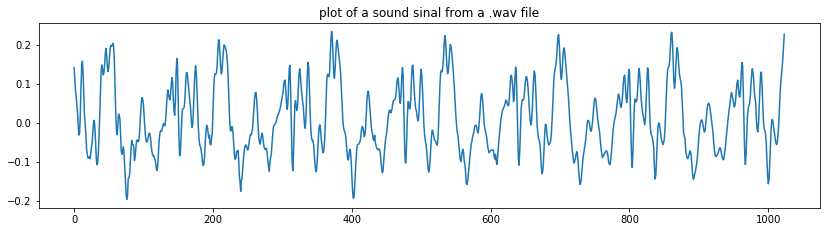

In [8]:
speech_file = '../data/music_speech/speech_wav/god.wav'

x, sf = librosa.load(speech_file)

print(f'shape: {x.shape}\nsampling freq: {sf}\ntime duration: len/sf = {x.shape[0]/sf} seconds')
plt.title('plot of a sound sinal from a .wav file')
plt.plot(x[:1024]);

In [9]:
import IPython.display as ipd
ipd.Audio(speech_file)

Text(0.5, 1.0, 'a speech waveplot')

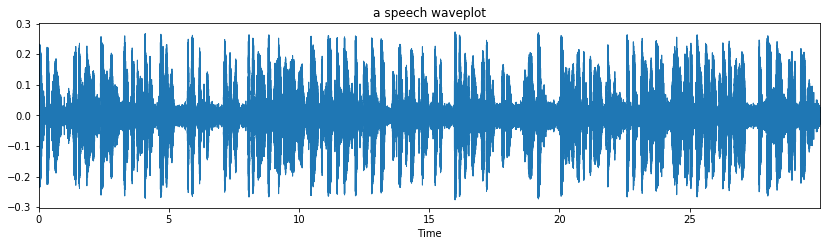

In [10]:
import librosa.display
#plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sf)
plt.title('a speech waveplot')

----

## Music Speech Classification

- Each training data is 30 seconds long.
- We will use only N samples (T = N/sf seconds) randomly chosen from 30 seconds long sequence for training/testing.
    - 1 second = sf samples (22050 samples/sec,  or 44100 samples/sec)
- We will use .wav only. The dataset provide data in two formats: .au and .wav.  

### Data file list up

In [12]:
import os

class_names = ['music', 'speech']
data_dir = {'music' : '../data/music_speech/music_wav', 
            'speech': '../data/music_speech/speech_wav'}

wav_files = {cls_name: [] for cls_name in class_names}
for cls_name in class_names:
    folder = data_dir[cls_name]
    filelist = os.listdir(folder)
    for filename in filelist:
        if filename[-4:] == '.wav':
            wav_files[cls_name].append(os.path.join(folder, filename))

In [13]:
print([len(wav_files[c]) for c in class_names])
wav_files['music'][:3]

[64, 64]


['../data/music_speech/music_wav\\bagpipe.wav',
 '../data/music_speech/music_wav\\ballad.wav',
 '../data/music_speech/music_wav\\bartok.wav']

### Train/Validation Split

In [14]:
np.random.seed(1)

file_list = {'train': [], 'val': []}
for class_id, c in enumerate(class_names):
    n_data = len(wav_files[c])
    rindx = np.random.permutation(n_data)
    n_validation = int(0.25*n_data)
    v_indx = rindx[:n_validation]
    t_indx = rindx[n_validation:]
    file_list['train'] += [ (wav_files[c][k], class_id) for k in t_indx ] 
    file_list['val'] += [ (wav_files[c][k], class_id) for k in v_indx ] 
#     file_list['']

In [15]:
[ len(file_list[tv]) for tv in ['train', 'val'] ]

[96, 32]

### Dataset

In [38]:
import torch
import numpy as np
import librosa # audio file manipulation

class MSDataset(torch.utils.data.Dataset):
    """ Music/Speech Classification 
        filelist: [(file_path, class_id)]
        sample_time: time duration to sample from .wav file
                     the sample is extracted somewhere in the middle of the whole sequence
                     similar to data augmentation
                     
         Validation dataset: the first segment of the sequence is used.
                             Another option is to apply several segments and accumulate multiple inferences
    """
    def __init__(self, filelist, sample_sec=5., is_train=True):
        self.filelist = filelist
        self.time_duration = sample_sec
        self.is_train = is_train
        
        _, sf = librosa.load(filelist[0][0])
        self.sf = sf
        self.n_features = int(self.time_duration * sf)
        
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, i):
        # 1. load the file
        # 2. sample a segment of the length from the whole seq
        # 3. return segment, id
        audio_file, class_id = self.filelist[i]
        x, sf = librosa.load(audio_file)

        if self.is_train:
            k = np.random.randint(low=0, high=x.shape[0]-self.n_features) # choose the start index
        else:
            k = 0
        
        x = torch.from_numpy(x[k:k+self.n_features]).reshape(1,-1)
        
        return x, class_id
    
    def load(self, audio_file):
        return librosa.load(audio_file)

### Sanity Check

dataset length:  96 torch.float32 torch.Size([1, 110250]) 1


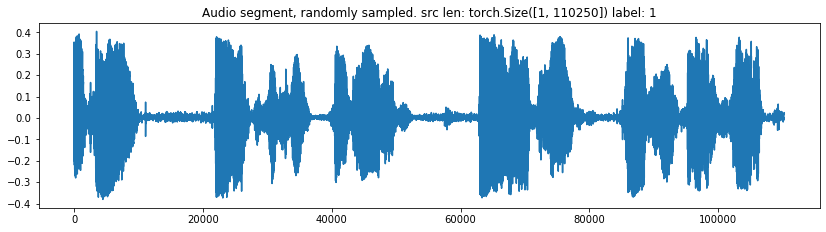

In [44]:
ds = MSDataset(file_list['train'], sample_sec=5, is_train=True)

x, label = ds[-1]

print('dataset length: ', len(ds), x.dtype, x.shape, label)#label.dtype, label.shape)

plt.title(f'Audio segment, randomly sampled. src len: {x.shape} label: {label}');
plt.plot(x.reshape(-1)); 

### Dataloader for train/validation

In [61]:
sample_sec = 2
batch_size = 2

data_loader = {tv: 
                   torch.utils.data.DataLoader(
                                               MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=True,
                                               )
               for tv in ['train', 'val']}
#
data_loader

{'train': <torch.utils.data.dataloader.DataLoader at 0x2456a66da08>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x2450acfd6c8>}

## Network Model Design

In [82]:
import torch.nn as nn

def myNetworkModel(in_channels, n_targets, option=1):
    if option == 1:
        kernel_size = 17
        net = nn.Sequential(
                        nn.Conv1d(in_channels=in_channels, out_channels=100, kernel_size=kernel_size, stride=kernel_size//2),
                        nn.ReLU(inplace=True),
                        nn.Conv1d(in_channels=100, out_channels=2, kernel_size=kernel_size, stride=kernel_size//2),
                        nn.ReLU(inplace=True),
                        nn.AdaptiveAvgPool1d(1),
                        nn.Flatten()               # Don't forget to use nn.CrossEntropyLoss()
                        )

    pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f'myNetworkModel()  in: {in_channels}  out: {n_targets}', 'n_params (K): ', pytorch_total_params)
    
    return net
#

### Sanity Check: Dataloader + Model

In [83]:
n_channels = 1
n_targets  = 2

model = myNetworkModel(n_channels, n_targets)
model

myNetworkModel()  in: 1  out: 2 n_params (K):  5202


Sequential(
  (0): Conv1d(1, 100, kernel_size=(17,), stride=(8,))
  (1): ReLU(inplace=True)
  (2): Conv1d(100, 2, kernel_size=(17,), stride=(8,))
  (3): ReLU(inplace=True)
  (4): AdaptiveAvgPool1d(output_size=1)
  (5): Flatten()
)

In [84]:
x, y = next(iter(data_loader['train']))
print(x.shape, x.dtype, y.shape, y.dtype)
x, y

torch.Size([2, 1, 44100]) torch.float32 torch.Size([2]) torch.int64


(tensor([[[ 0.0975,  0.0996,  0.1154,  ..., -0.0823, -0.0657, -0.0387]],
 
         [[-0.0564, -0.0582, -0.0535,  ...,  0.0222,  0.0257,  0.0282]]]),
 tensor([0, 1]))

In [85]:
with torch.no_grad():
    for data, label in data_loader['train']:
        print('batch shape: ', data.shape, label.shape, label)
        ypred = model(data)
        print(ypred)
        print(torch.argmax(ypred, dim=1))
        break

batch shape:  torch.Size([2, 1, 44100]) torch.Size([2]) tensor([0, 1])
tensor([[0.0052, 0.0581],
        [0.0003, 0.0617]])
tensor([1, 1])


## Trainin Loop

In [86]:
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None):
    if hist is not None:
        pass
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
    best_acc = 0
    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()
   
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        #
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val)
        
        if epoch <= 5 or epoch % 1000 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.2f}  vloss {val_loss:.2f}  v_acc: {val_acc:.2f}')
        else:
            if best_acc < val_acc:
                best_acc = val_acc
                print(' best val accuracy updated: ', best_acc)
        #
        # record for history return
        hist['tloss'].append(tr_loss)
        hist['vloss'].append(val_loss) 
        hist['tacc'].append(tr_acc)
        hist['vacc'].append(val_acc)
        
    print ('finished training_loop().')
    return hist
#

def performance(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    return loss, acc
#
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    max_vacc = max(history['vacc'])
    axes[1].set_title(f'Acc. vbest: {max_vacc:.2f}')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()
#

## Model, Optimizer & Loss Function

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# model
in_channels = 1
n_targets = 2

model = myNetworkModel(in_channels, n_targets).to(device)

# optim
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None

cuda
myNetworkModel()  in: 1  out: 2 n_params (K):  5202


## First Trial

Epoch 1, tloss 1.15 t_acc: 0.60  vloss 0.68  v_acc: 0.62
Epoch 2, tloss 0.67 t_acc: 0.67  vloss 0.69  v_acc: 0.66
Epoch 3, tloss 0.64 t_acc: 0.69  vloss 0.70  v_acc: 0.53
Epoch 4, tloss 0.61 t_acc: 0.64  vloss 0.95  v_acc: 0.50
Epoch 5, tloss 0.67 t_acc: 0.64  vloss 0.69  v_acc: 0.59
 best val accuracy updated:  0.53125
 best val accuracy updated:  0.5625
 best val accuracy updated:  0.6875
Epoch 10, tloss 0.68 t_acc: 0.68  vloss 0.68  v_acc: 0.56
finished training_loop().


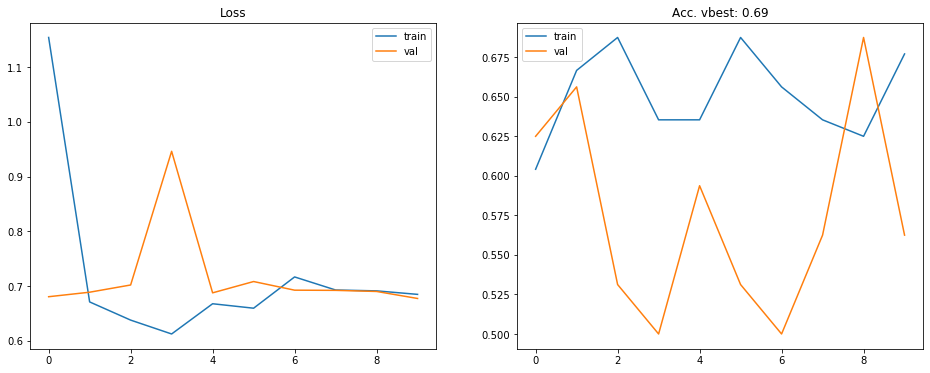

In [94]:
history = training_loop(10, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
plot_history(history)

### Train More

Epoch 1, tloss 0.68 t_acc: 0.64  vloss 0.68  v_acc: 0.59
Epoch 2, tloss 0.65 t_acc: 0.66  vloss 0.65  v_acc: 0.50
Epoch 3, tloss 0.66 t_acc: 0.57  vloss 0.68  v_acc: 0.53
Epoch 4, tloss 0.59 t_acc: 0.62  vloss 0.73  v_acc: 0.53
Epoch 5, tloss 0.62 t_acc: 0.77  vloss 0.65  v_acc: 0.56
 best val accuracy updated:  0.65625
 best val accuracy updated:  0.6875
 best val accuracy updated:  0.71875
 best val accuracy updated:  0.75
 best val accuracy updated:  0.8125
 best val accuracy updated:  0.84375
Epoch 500, tloss 0.55 t_acc: 0.73  vloss 0.52  v_acc: 0.72
finished training_loop().


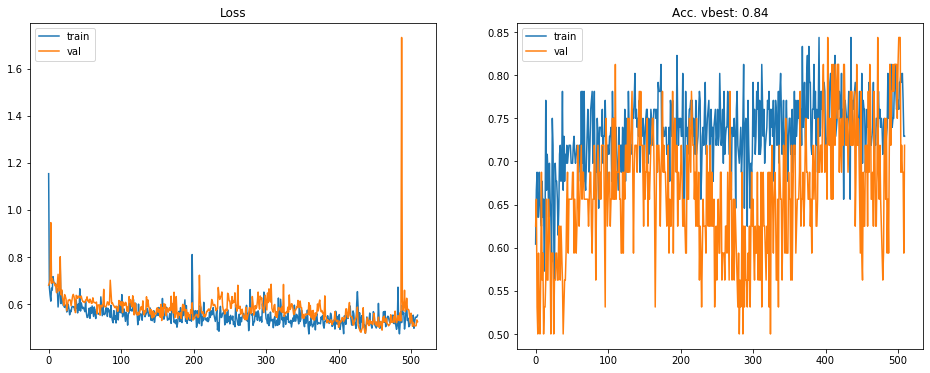

In [95]:
history = training_loop(500, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
plot_history(history)

The experiment was performed with RTX 2070, 8G memory.

## Practicum
1. Modify hyper parameters to increase the validation accuracy
    - the number of network layers
    - the size of the input features    
    - learning rate
    - SGD or Adam
    - learning rate scheduler
1. Is there a method to reduce the feature dimension of the input data?
1. Suggest what else we need to think about.
1. Is the problem modelling itself appropriate?
1. Do we need to change the validation method?

End.